In [9]:
import glob
import lxml.etree as ET
from pandas import Series, DataFrame
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.chdir("/home/thibault/dev/these/")

NS = {"t": "http://www.tei-c.org/ns/1.0"}

xml = ET.parse("these-corpus/collated.xml")

print(len(xml.xpath("//t:div", namespaces=NS)))
print(len(xml.xpath("//t:w[@pos!='PUNC']", namespaces=NS)))

2516
38201


# Tags

## Tags les plus communs

[('acte', 1288), ('metonymie', 789), ('male', 573), ('metaphore', 459), ('female', 419), ('mentula', 399), ('euphemism', 379), ('cunnus', 305), ('composite', 299), ('womb', 213), ('culus', 162), ('fututio', 113), ('violence', 104), ('coeo', 94), ('adjoiningParts', 93), ('amo', 91), ('aidoion', 80), ('dormirAvec', 71), ('specialisation', 70), ('animal', 59)]
199
8215


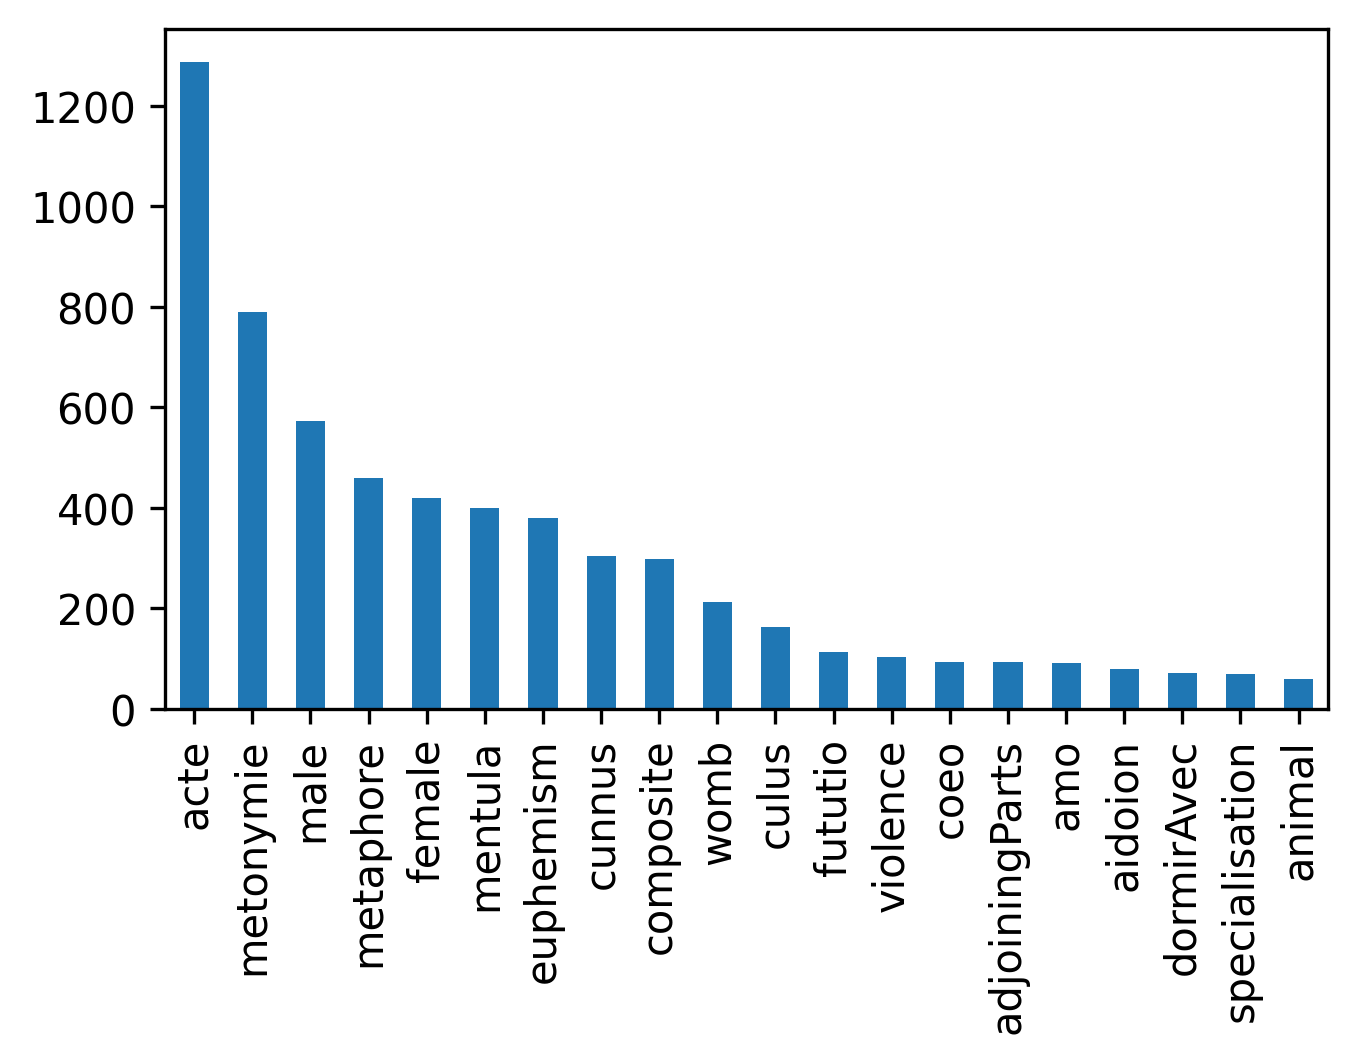

In [2]:
anas = Counter([tag[1:] for ana in xml.xpath("//t:div/@ana", namespaces=NS) for tag in ana.split()])
print(anas.most_common(20))

fig = plt.figure(figsize=(5,3), dpi=300)

Series(dict(anas.most_common(20))).plot.bar(ax=plt.gca())
print(len(anas))
print(sum(list(anas.values())))

In [3]:
len(set(['='.join(sorted([tag[1:] for tag in ana.split()])) for ana in xml.xpath("//t:div/@ana", namespaces=NS)]))

342

## Co-occurrence de tags

<AxesSubplot:xlabel='Catégorie 2', ylabel='Catégorie 1'>

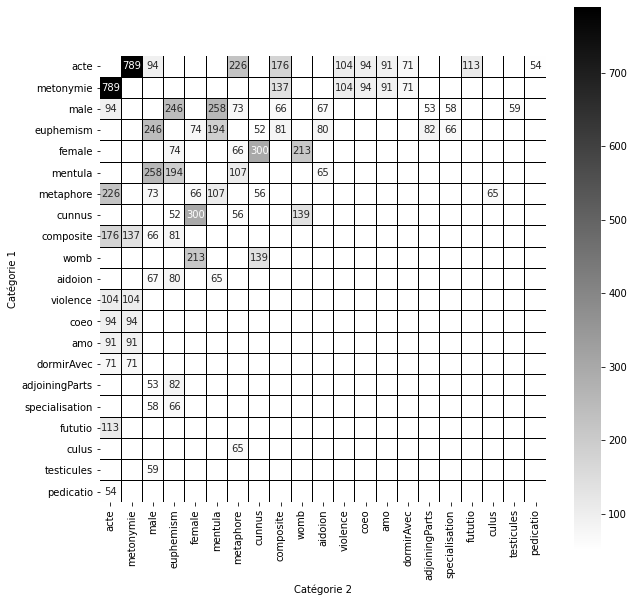

In [4]:
combined = Counter([
    (tag1[1:], tag2[1:])
    for ana in xml.xpath("//t:div/@ana", namespaces=NS)
    for tag1 in ana.split()
    for tag2 in ana.split()
    if tag1 != tag2
])
matrix = {
    a_tag: {
        tag2: amount
        for (tag1, tag2), amount in combined.items()
        if a_tag == tag1
    }
    for a_tag in anas.keys()
}

accounts = [
    {"Catégorie 1": tag1, "Catégorie 2": tag2, "Compte": amount}
    for (tag1, tag2), amount in combined.items()
]
matrix = DataFrame(accounts)

MIN = 50

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
piv = matrix[matrix.Compte > MIN].pivot("Catégorie 1", "Catégorie 2", "Compte")
order = piv.sum(axis=1).sort_values(ascending=False).index
sns.heatmap(
    piv[order].loc[order],
    cmap=sns.color_palette("gray_r", as_cmap=True),
    square=True,
    vmin=MIN,
    annot=True,
    fmt=".0f",
    linecolor="#000000",
    linewidths=.05,
    ax=ax
)

#print(matrix[(matrix["Catégorie 1"] == "violence") & (matrix["Compte"] > 0)])


Text(114.0, 0.5, '')

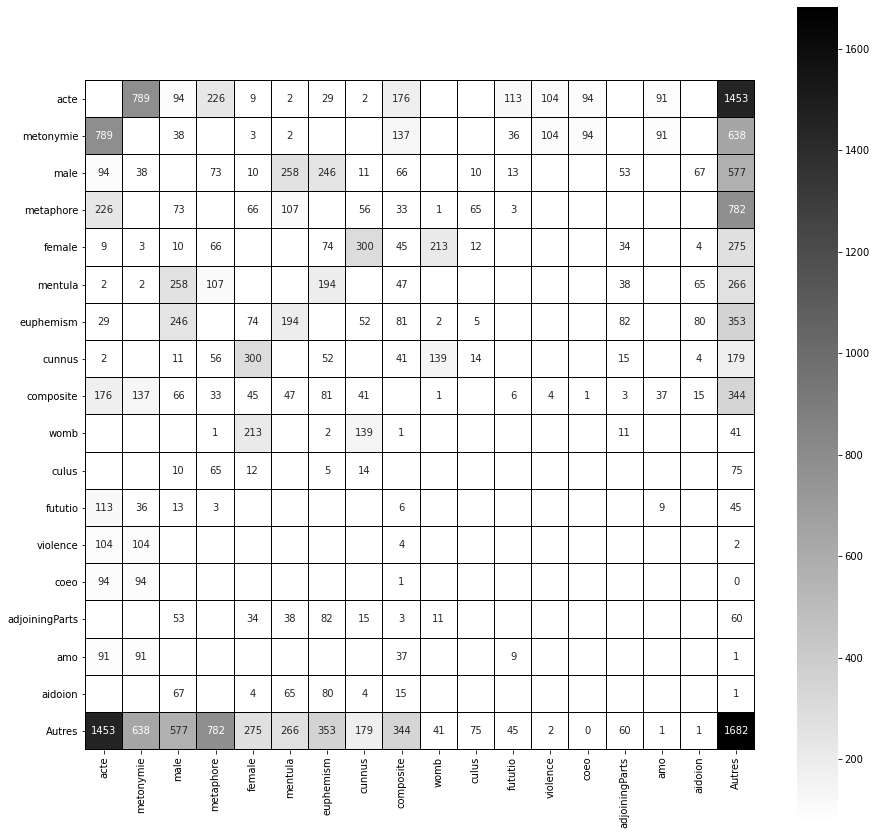

In [5]:
MIN = 75
# Copy the original matrix to not void the previous work
matrix2 = matrix.copy()
# Make the pivot early, without filtering
piv2 = matrix.pivot("Catégorie 1", "Catégorie 2", "Compte")

# Retrieve element whose sum of apparition are higher than 50
kept = [key for key, val in anas.items() if val > MIN]
autre = set(matrix["Catégorie 1"].unique()) - set(kept)
order = sorted(kept, key=lambda x: anas[x], reverse=True)


piv2["Autres"] = piv2.sum(axis=1) - piv2[order].sum(axis=1)
#print(order.tolist())
#dict(zip(piv2.loc[order.tolist()].columns, piv2["Autres"].loc[order.tolist()].tolist()))
autres = piv2["Autres"].loc[autre].sum()
dico = piv2["Autres"].loc[order].to_dict()
dico["Autres"] = autres
piv2.loc["Autres"] = dico

fig = plt.figure(figsize=(15,15))
ax = fig.gca()
sns.heatmap(
    piv2[order+["Autres"]].loc[order+["Autres"]],
    cmap=sns.color_palette("gray_r", as_cmap=True),
    square=True,
    vmin=MIN,
    annot=True,
    fmt=".0f",
    linecolor="#000000",
    linewidths=.05,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")

## Zoom sur des tags

<AxesSubplot:xlabel='Page', ylabel='Tag'>

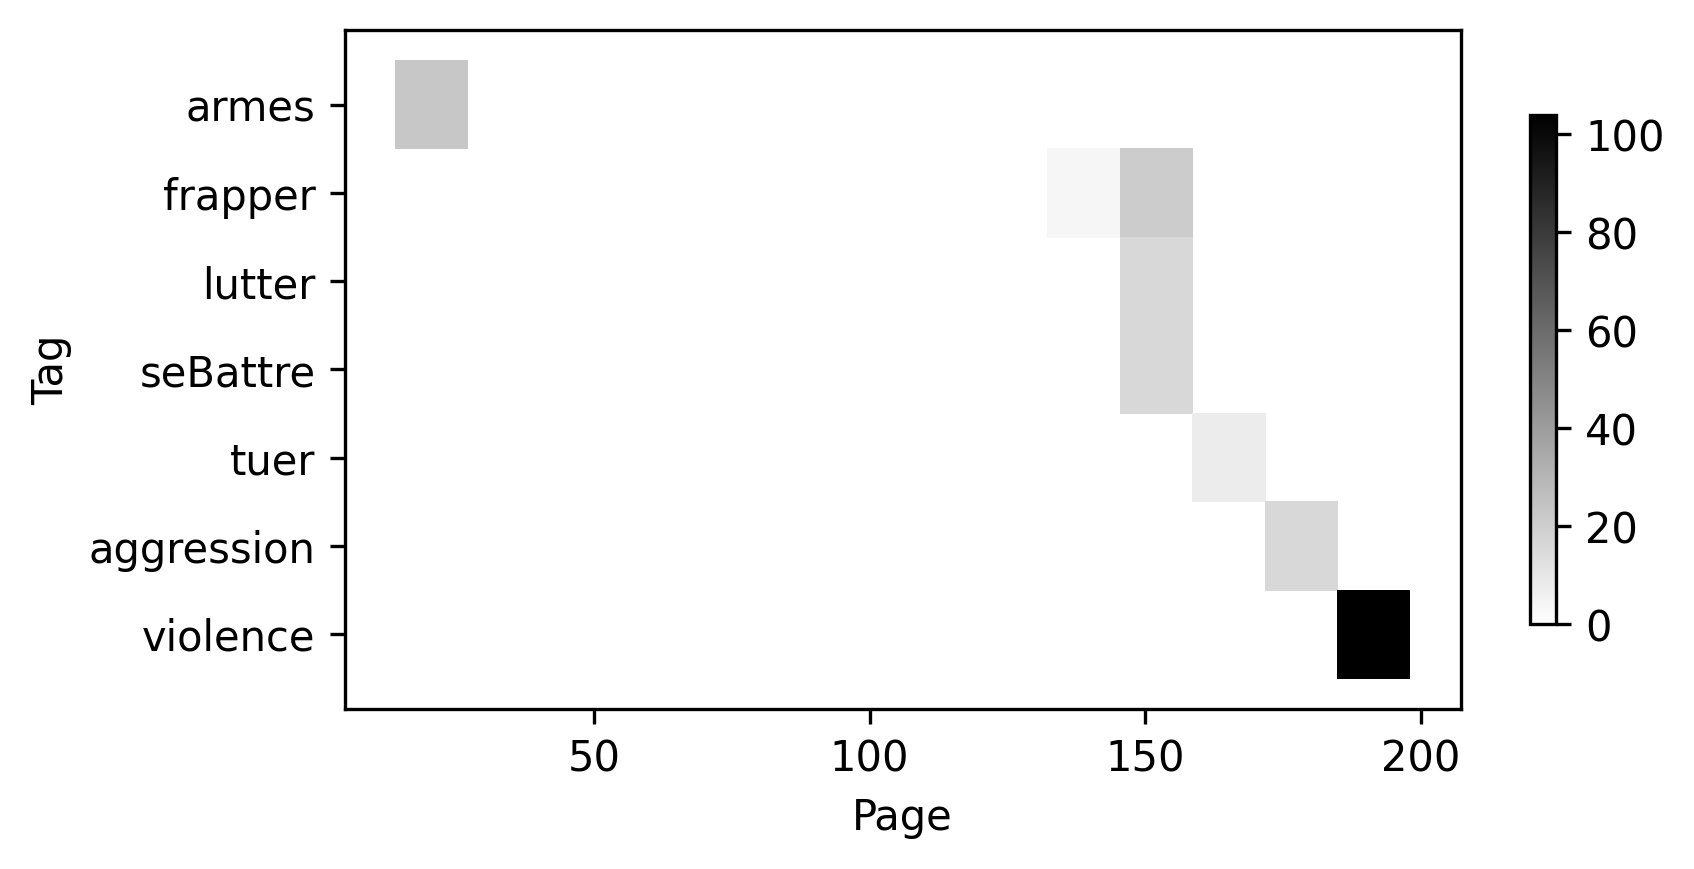

In [6]:
EvolutionOfTags = []

for (element, div) in enumerate(xml.xpath("//t:div", namespaces=NS)):
    page = div.xpath(".//t:biblScope[@unit='page']/text()", namespaces=NS)[0]
    ana = div.xpath("./@ana", namespaces=NS)[0]
    for tag in ana.split(" "):
        EvolutionOfTags.append({
            "Page": int(page),
            "Tag": tag[1:],
            "Count": 1
        })

df = DataFrame(EvolutionOfTags)
#df = df.groupby(["Page", "Tag"])["Count"].sum().reset_index()
df = df.sort_values("Page")

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

sns.histplot(
    data=df[
        df.Tag.isin(["armes", "violence", "tuer", "aggression", "seBattre", "lutter", "frapper"])
    ].sort_values("Page"),
    x="Page",
    y="Tag",
    #style="Tag",
    #hue="Tag",
    cbar=True, cbar_kws=dict(shrink=.75),
    ax=ax,
    palette="Grays",
    cmap=sns.color_palette("gray_r", as_cmap=True),
)

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#.plot.scatter(x="Page", y="Count")
#df.Tag.unique()

# Importance des auteurs

In [7]:
authors = Counter(xml.xpath("//t:div/t:bibl[@type='source']//t:persName[@xml:lang='fr']/text()", namespaces=NS))

Text(0.5, 0, 'Dispersion du nombre \nde documents par auteurs')

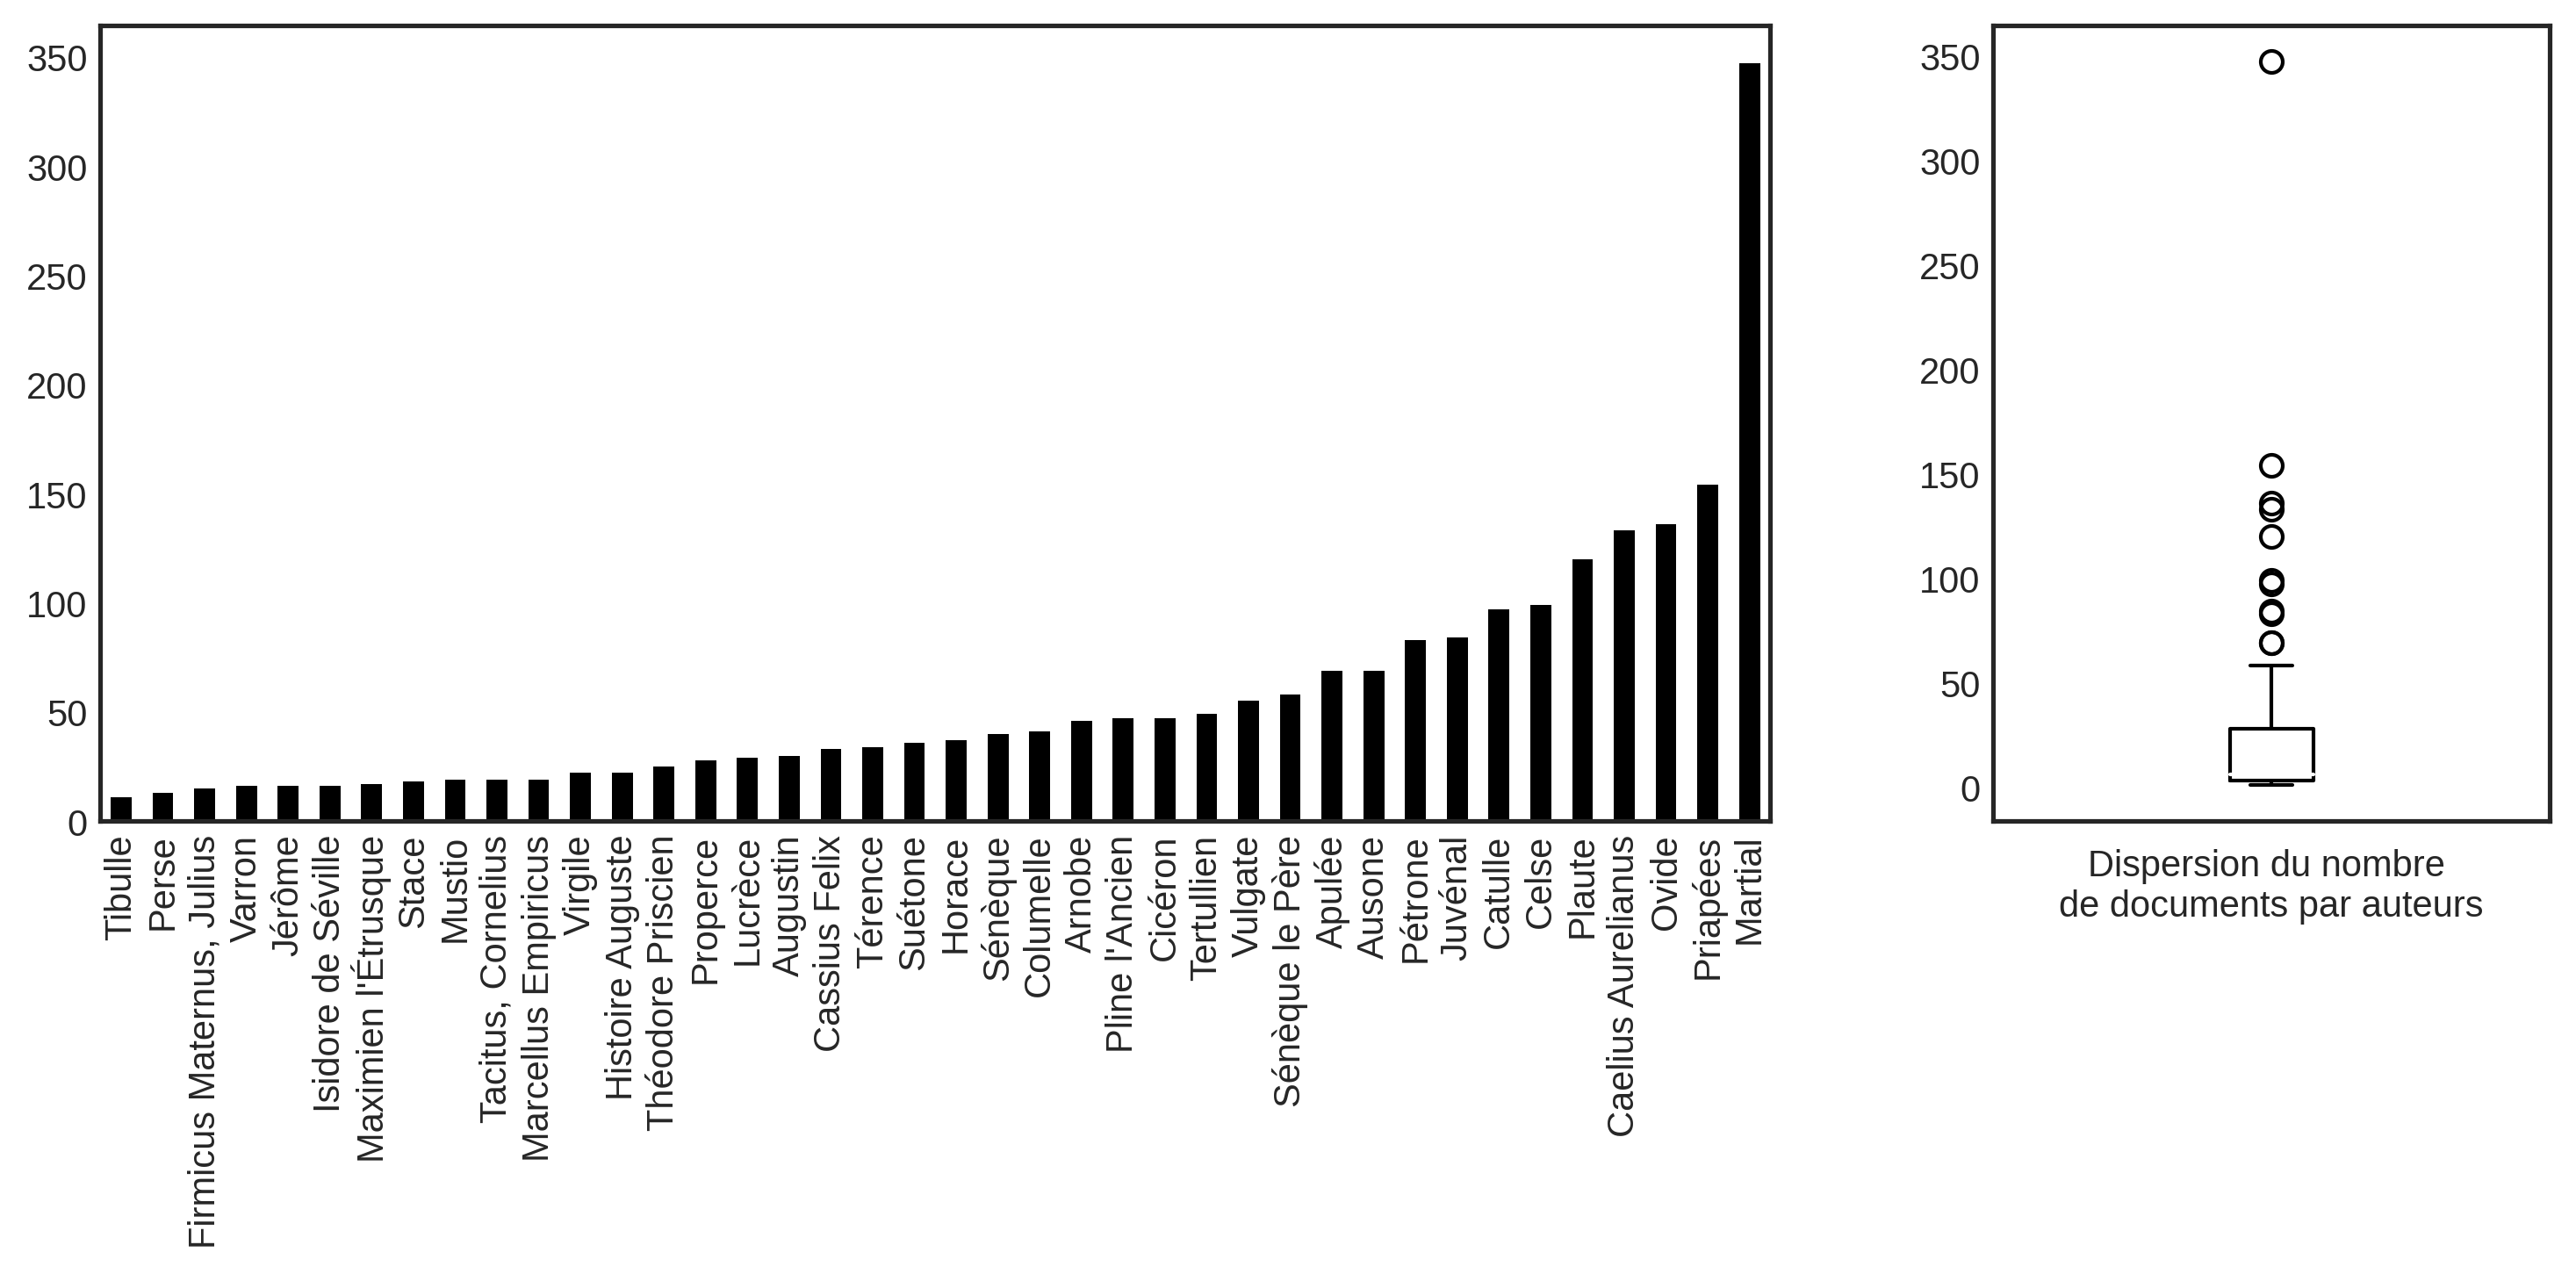

In [8]:
plt.style.use('seaborn-white')
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
S = Series(authors)
S[S > 10].sort_values().plot.bar(ax=ax1,
    cmap=sns.color_palette("gray", as_cmap=True))
S.plot.box(ax=ax2,
    cmap=sns.color_palette("gray", as_cmap=True))
ax2.set_xticklabels([""])
ax2.set_xlabel("Dispersion du nombre \nde documents par auteurs")

# Importance dans le corpus / importance dans Adams

In [149]:
import glob
from collections import defaultdict
from MyCapytain.common.reference import URN

already_read = []
all_authors = defaultdict(lambda: 0)

for file in glob.glob("../latin-lemmatized-texts/lemmatized/xml/*.xml"):
    local_xml = ET.parse(file)
    urn = local_xml.xpath("//t:idno/text()", namespaces=NS)[0]
    if str((URN(urn)).upTo(URN.WORK)) in already_read:
        continue
    already_read.append(str((URN(urn)).upTo(URN.WORK)))
    urn = str((URN(urn)).upTo(URN.TEXTGROUP))
    words = len(local_xml.xpath("//t:w[@pos!='PUNC']", namespaces=NS))
    all_authors[urn] += words

In [150]:
authors = Counter(
    work.split(".")[0]
    for work in xml.xpath(
        "//t:idno[@type='CTS_URN']/text()",
        namespaces=NS
    )
)
name_authors = dict([
    (
        sample.xpath("./t:idno[@type='CTS_URN']/text()", namespaces=NS)[0].split(".")[0],
        (
            sample.xpath(".//t:persName[@xml:lang='fr']/text()", namespaces=NS) + \
            sample.xpath(".//t:title[@xml:lang='lat']/text()", namespaces=NS)
        )[0].split("/")[0].strip()
    )
    for sample in xml.xpath(
        "//t:bibl[@type='source']",
        namespaces=NS
    )
])
example_word_counts = defaultdict(lambda:0)
for sample in xml.xpath("//t:quote", namespaces=NS):
    try:
        example_word_counts[sample.attrib["source"].split(".")[0]] += len(
            sample.xpath(".//t:w[@pos!='PUNC']", namespaces=NS)
        )
    except:
        print(ET.tostring(sample, encoding=str))

In [151]:
df = DataFrame([
    [name_authors.get(tg, "Inconnu"), tg, words, authors.get(tg, 0), example_word_counts.get(tg, 0)]
    for tg, words in all_authors.items()
], columns=["Auteur", "Textgroup", "MotsComplet", "Exemples", "MotsExemples"])
df["MotsComplet%"] = df["MotsComplet"] / df["MotsComplet"].sum()
df["MotsExemples%"] = df["MotsExemples"] / df["MotsExemples"].sum()
df["Exemples%"] = df["Exemples"] / df["Exemples"].sum()
df["Exemples%/MotsComplet%"] = df["Exemples%"] / df["MotsComplet%"]
df["MotsExemples%/MotsComplet%"] = df["MotsExemples%"] / df["MotsComplet%"]
df["MotsExemples/MotsComplet"] = df["MotsExemples"] / df["MotsComplet"]
df[df["Exemples%/MotsComplet%"] != .0].sort_values("Exemples%/MotsComplet%", ascending=False)

,Auteur,Textgroup,MotsComplet,Exemples,MotsExemples,MotsComplet%,MotsExemples%,Exemples%,Exemples%/MotsComplet%,MotsExemples%/MotsComplet%,MotsExemples/MotsComplet
106,Priapées,urn:cts:latinLit:phi1103,3477,154,1997,0.000216,0.052445,0.061551,285.244399,243.045534,0.574346
176,Catulle,urn:cts:latinLit:phi0472,13080,97,1227,0.000812,0.032223,0.038769,47.760084,39.696397,0.093807
158,Martial,urn:cts:latinLit:phi1294,57582,347,4089,0.003574,0.107385,0.138689,38.810016,30.050011,0.071012
32,Maximien l'Étrusque,urn:cts:latinLit:stoa0196,4310,17,263,0.000267,0.006907,0.006795,25.402283,25.822171,0.061021
194,Juvénal,urn:cts:latinLit:phi1276,25404,84,1149,0.001577,0.030175,0.033573,21.295031,19.139571,0.045229
...,...,...,...,...,...,...,...,...,...,...,...
15,De Lapsu virginis consecratae liber,urn:cts:latinLit:stoa0022,524393,9,178,0.032544,0.004675,0.003597,0.110532,0.143641,0.000339
27,Eugraphius,urn:cts:latinLit:stoa0119a,68842,1,16,0.004272,0.000420,0.000400,0.093551,0.098351,0.000232
35,Hilaire,urn:cts:latinLit:stoa0149b,238047,3,36,0.014773,0.000945,0.001199,0.081163,0.063996,0.000151
120,Justinien,urn:cts:latinLit:stoa0168,1219008,9,115,0.075652,0.003020,0.003597,0.047549,0.039921,0.000094


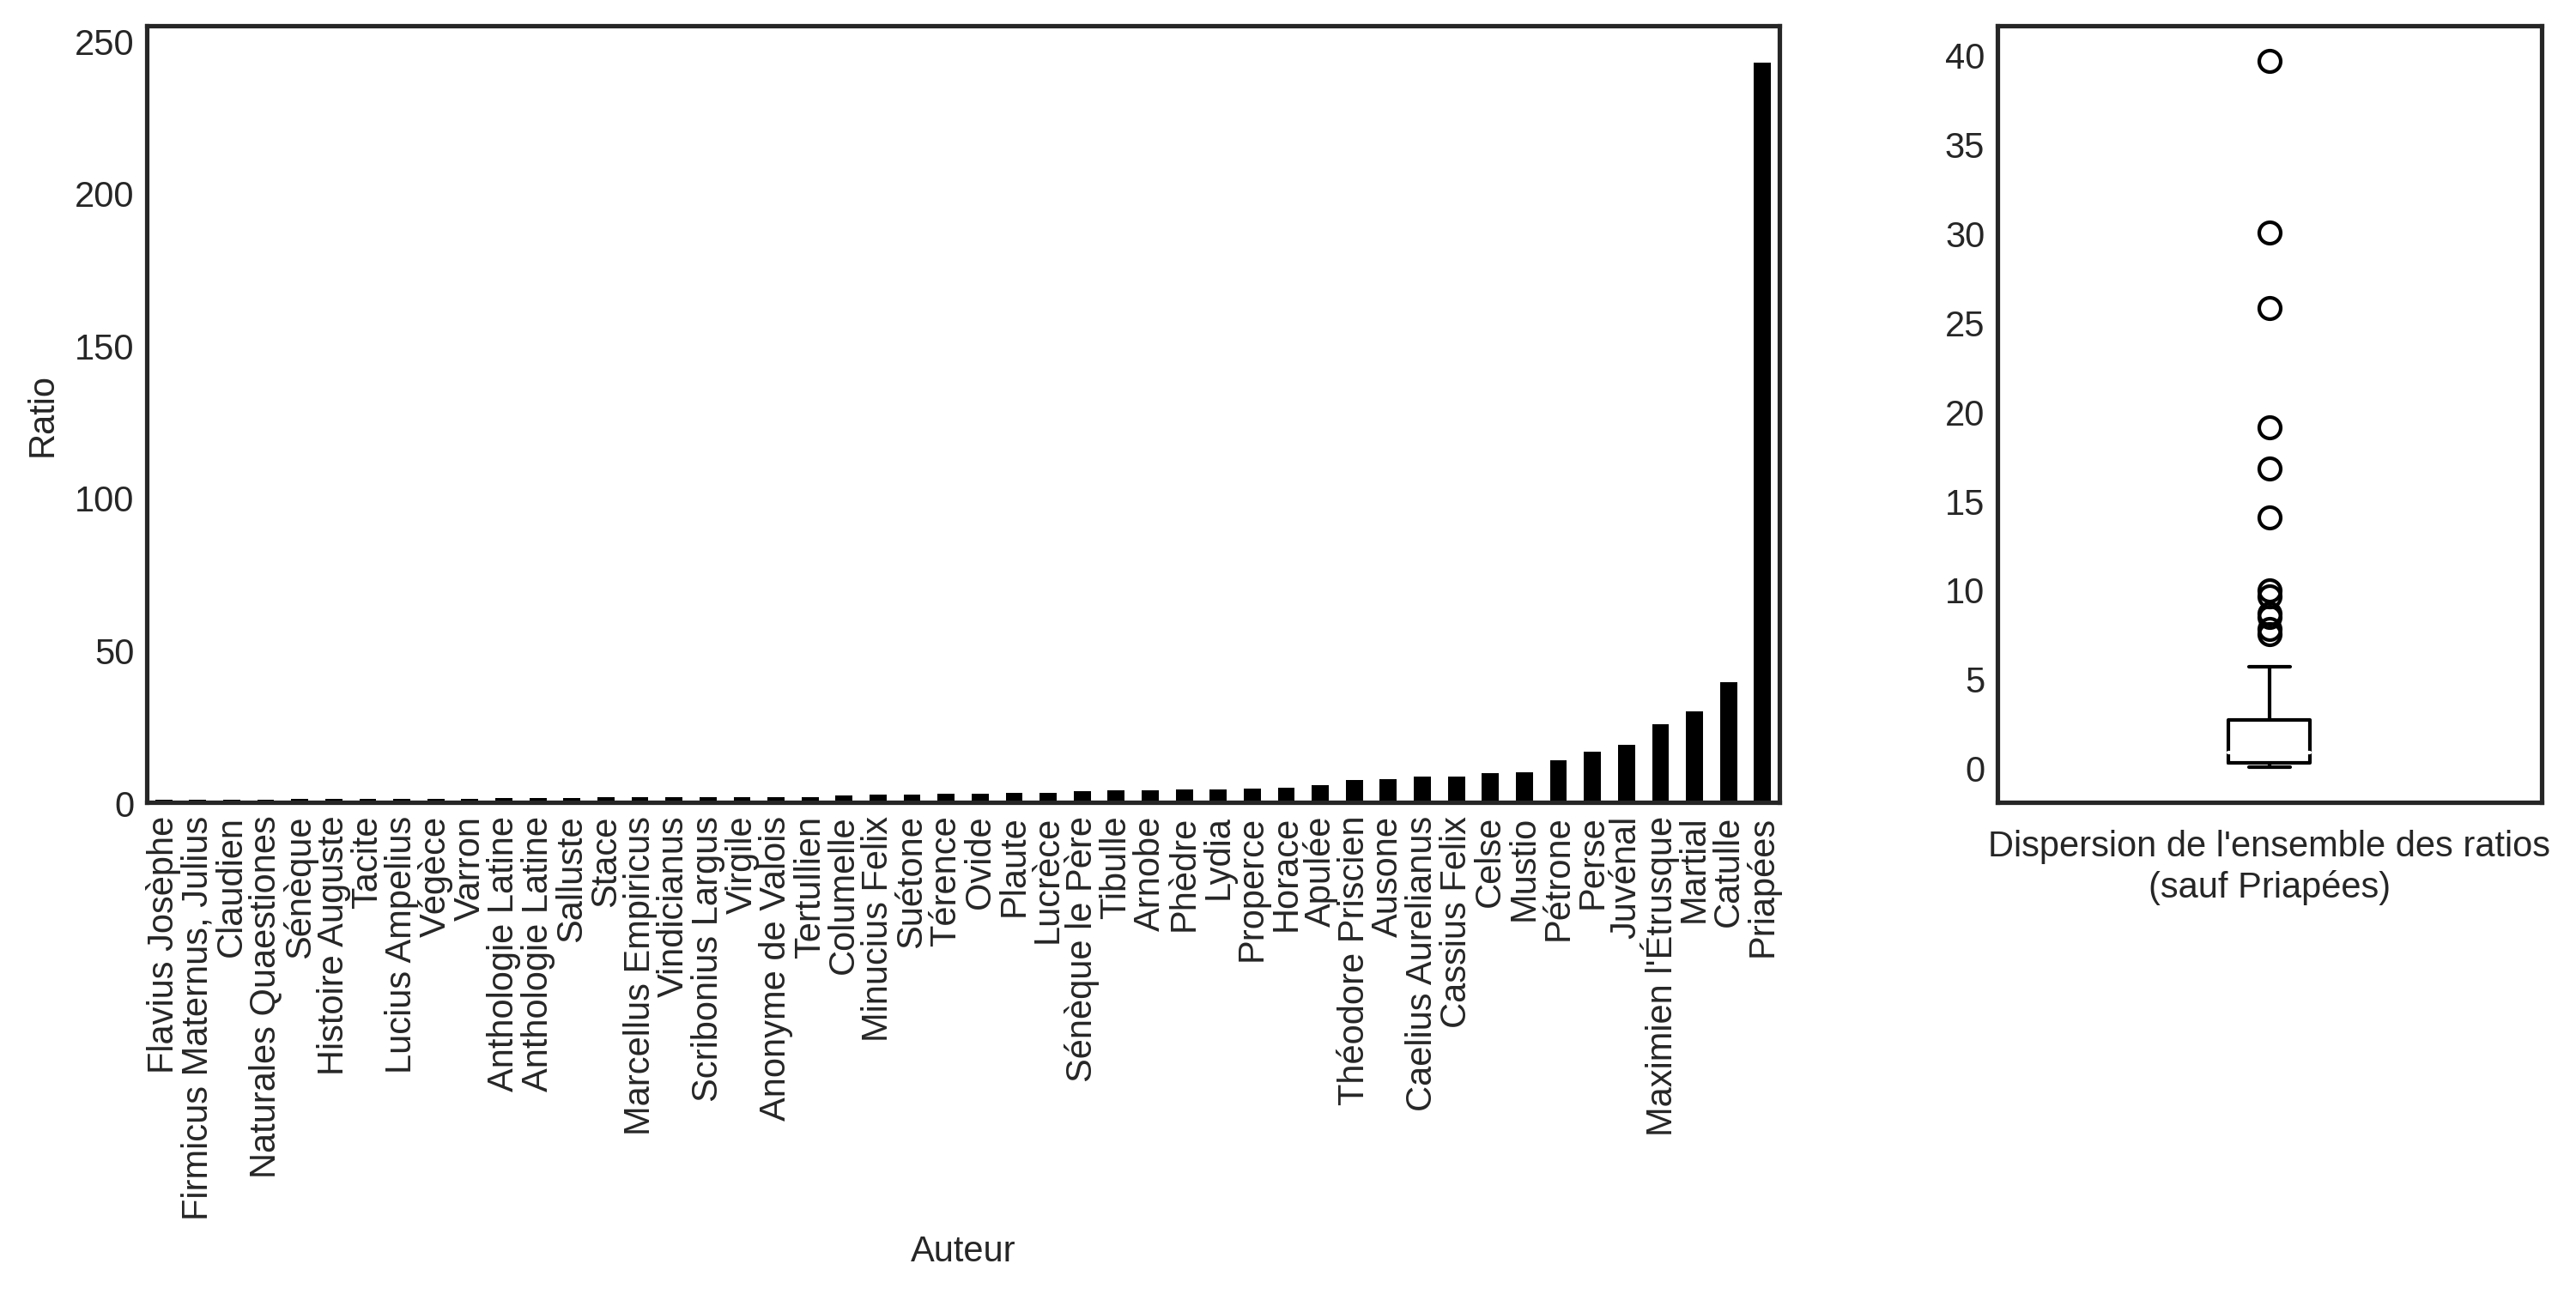

In [152]:
plt.style.use('seaborn-white')
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
df[df["MotsExemples%/MotsComplet%"] >= .9].sort_values("MotsExemples%/MotsComplet%").plot.bar(
    x="Auteur",
    y="MotsExemples%/MotsComplet%",
    #log=True,
    ax=ax1,
    cmap=sns.color_palette("gray", as_cmap=True)
)
df["MotsExemples%/MotsComplet%"][df["MotsExemples%/MotsComplet%"].between(.01, 100)].plot.box(ax=ax2,
    cmap=sns.color_palette("gray", as_cmap=True))
ax2.set_xticklabels([])
ax2.set_xlabel("Dispersion de l'ensemble des ratios\n(sauf Priapées)")
ax1.set_ylabel("Ratio")
ax1.legend().remove()

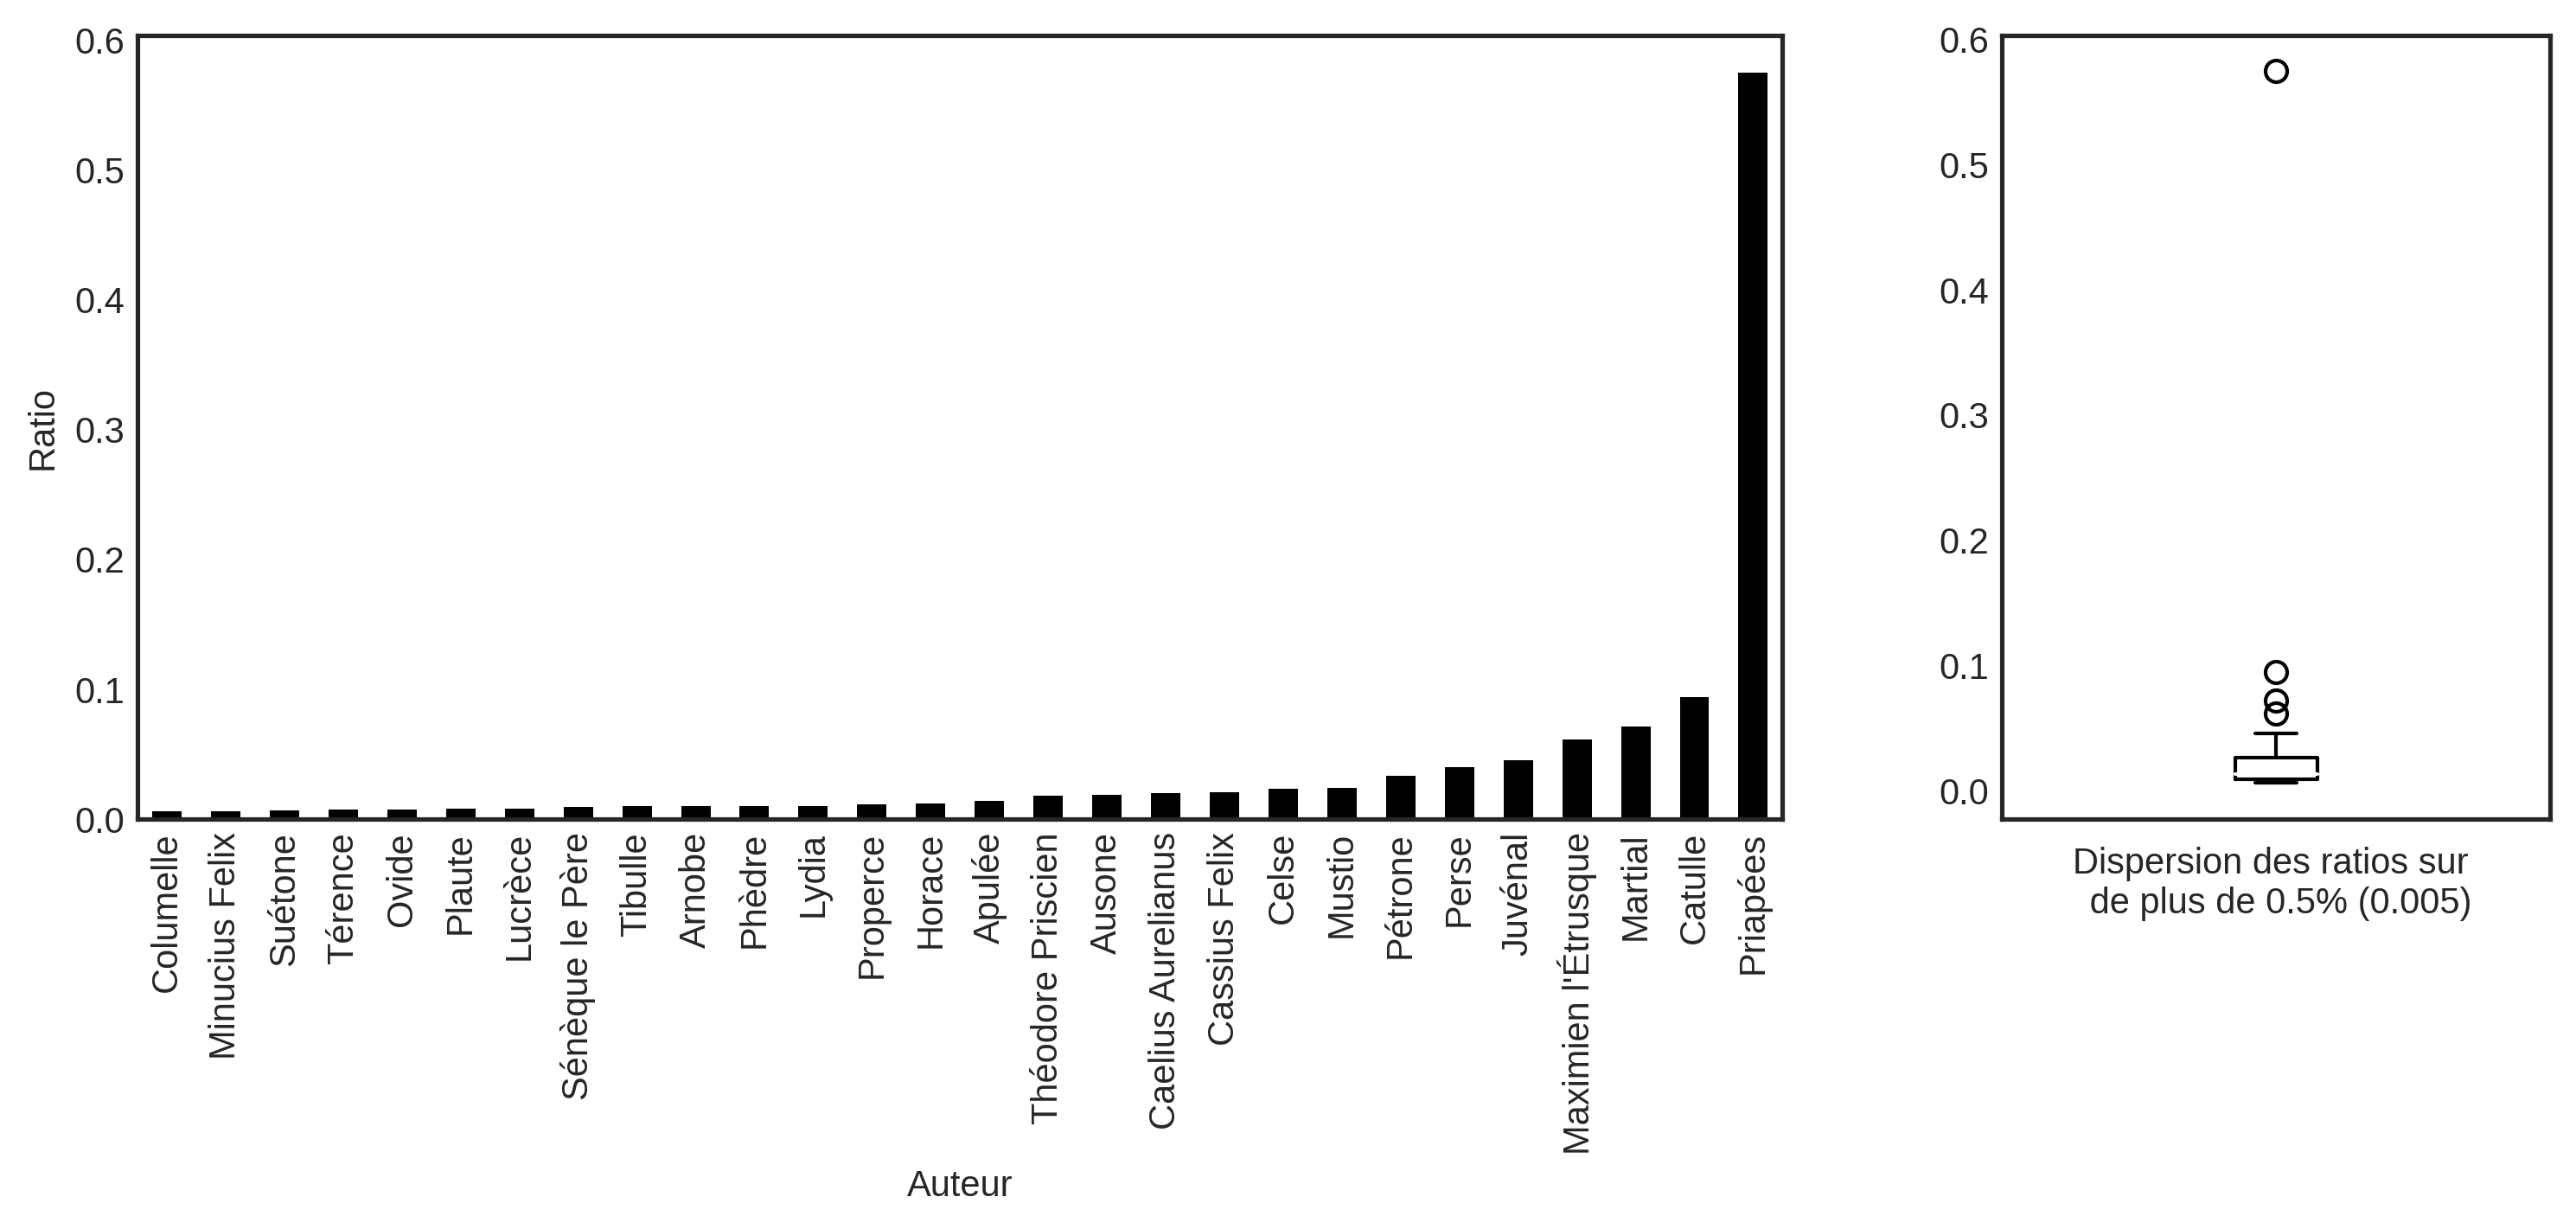

In [154]:
plt.style.use('seaborn-white')
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
df[df["MotsExemples/MotsComplet"] >= .005].sort_values("MotsExemples/MotsComplet").plot.bar(
    x="Auteur",
    y="MotsExemples/MotsComplet",
    #log=True,
    ax=ax1,
    cmap=sns.color_palette("gray", as_cmap=True)
)
#sns.histplot(df["MotsExemples/MotsComplet"], ax=ax2, scale="log")
df["MotsExemples/MotsComplet"][df["MotsExemples/MotsComplet"].between(0.005, 1)].plot.box(ax=ax2,
    cmap=sns.color_palette("gray", as_cmap=True))
ax2.set_xticklabels([])
ax2.set_xlabel("Dispersion des ratios sur \n de plus de 0.5% (0.005)")
ax1.set_ylabel("Ratio")
ax1.legend().remove()

# Dates et auteurs

## Import data

In [81]:
from collections import namedtuple
import csv
Date = namedtuple("Date", ["birth", "death"])
dates = {}
NomsFr = {}

# On ouvre le fichier qui contient les dates
with open("./data/raw/datation.tsv") as f:
    reader = csv.DictReader(f, delimiter="\t")
    # Pour chacune des URN, on remplit avec le textgroup le dictionnaire data
    for line in reader:
        urn = line["URN"]
        # Si on a une URN et que cette ligne ne doit pas être ignorée
        if urn and line["Ignore"] != "x":
            textgroup = urn.split(".")[0]
            if textgroup not in dates:
                if not line["Birth"].lstrip('-').isdigit():
                    print("Error at following line")
                    print(line)
                else:
                    dates[textgroup] = Date(int(line["Birth"]), int(line["Death"]))
        else:
            print(f"Ignored {line['Work title']} / {line['Nom FR']}")
            
        if line.get("Nom FR"):
            nom_fr = line['Nom FR']
            if textgroup not in NomsFr:
                NomsFr[textgroup] = nom_fr
            
all_dates = list([d for tup in dates.values() for d in tup])
Min_date, Max_date = min(all_dates), max(all_dates)
print(Min_date, Max_date)

Ignored None / Rémi d'Auxerre
Ignored None / Pseudo-Hilarius
Ignored None / Granius Licinianus
Ignored None / Celse
Ignored None / Celse
Ignored None / Claudius Marius Victor
Ignored None / Pierre le Diacre
Error at following line
{'S': '', 'Ignore': '', 'URN': 'urn:cts:latinLit:stoa0364.stoa001.digilibLT-lat1', 'Nom FR': '', 'Birth': '', 'Death': '', 'certainty': '', 'Citation level': '2', 'Name of citation level': 'book,chapter', 'Sources': '', 'Sources Pages': '', 'Notes': '', 'Nom ENG': 'Mythographus Vaticanus I', 'Work title': 'Mythographus Vaticanus I'}
Error at following line
{'S': '', 'Ignore': '', 'URN': 'urn:cts:latinLit:stoa0365.stoa002.digilibLT-lat1', 'Nom FR': '', 'Birth': '', 'Death': '', 'certainty': '', 'Citation level': '1', 'Name of citation level': 'chapter,paragraph', 'Sources': '', 'Sources Pages': '', 'Notes': '', 'Nom ENG': 'De Taxone (Recensio β)', 'Work title': 'De Physiognomonia liber'}
Ignored None / Cornelius Labeo
Error at following line
{'S': '', 'Ignore'

In [82]:
AdditionalDates = {
    "urn:cts:latinLit:stoa0170a": (250, ),
    "urn:cts:latinLit:phi1257": (117, ),
    "urn:cts:latinLit:stoa0241d": (841, ),
    "urn:cts:latinLit:stoa0365": (350, ),
    "urn:cts:latinLit:stoa0364": (800, )
}

df["Date"] = df["Textgroup"].apply(lambda x: dates.get(x, AdditionalDates.get(x, (-999,)))[0])
#df.Date.plot.hist(bins=50)

df = df[~ df.Textgroup.isin(["urn:cts:latinLit:stoa0227b", "urn:cts:latinLit:stoa0359"])] # Remove Pierre Diacre, Vita Vergili Bernensis
df

,Auteur,Textgroup,MotsComplet,Exemples,MotsExemples,MotsComplet%,MotsExemples%,Exemples%,Exemples%/MotsComplet%,MotsExemples%/MotsComplet%,Date
0,Inconnu,urn:cts:latinLit:stoa0104p,69834,0,0,0.004334,0.000000,0.000000,0.000000,0.000000,205
1,Augustin,urn:cts:latinLit:stoa0040,1723611,30,574,0.106967,0.015074,0.011990,0.112094,0.140925,354
2,Sénèque le Père,urn:cts:latinLit:phi1014,98266,58,861,0.006098,0.022611,0.023181,3.801245,3.707782,-55
3,Cicéron,urn:cts:latinLit:phi0474,1170453,48,771,0.072638,0.020248,0.019185,0.264112,0.278750,-106
4,Sénèque,urn:cts:latinLit:stoa0255,76407,8,208,0.004742,0.005462,0.003197,0.674307,1.151979,-1
...,...,...,...,...,...,...,...,...,...,...,...
199,Marcellus Empiricus,urn:cts:latinLit:stoa0190a,100663,19,408,0.006247,0.010715,0.007594,1.215584,1.715160,350
200,Inconnu,urn:cts:latinLit:stoa0241d,12438,0,0,0.000772,0.000000,0.000000,0.000000,0.000000,841
201,Inconnu,urn:cts:latinLit:phi9500,112,0,0,0.000007,0.000000,0.000000,0.000000,0.000000,520
202,Inconnu,urn:cts:latinLit:dlt000386,46460,0,0,0.002883,0.000000,0.000000,0.000000,0.000000,289


## Évolution nombre d'auteurs

In [83]:
AuteursDate = df.copy()
AuteursDate.groupby("Auteur").count()["Date"]

Auteur
Ammien Marcellin     1
Anonyme de Valois    1
Anthologie Latine    2
Apulée               1
Arnobe               1
                    ..
Victor de Vita       1
Vindicianus          1
Virgile              1
Vulgate              2
Végèce               1
Name: Date, Length: 96, dtype: int64

## Évolution nombre de mots

In [84]:
from pandas import pivot_table

sns.set_palette("Set1")

DateRange = 50


NewDfBirth = df[df.Date != -999].sort_values(["Date"])
NewDfBirth.Date = NewDfBirth.Date.apply(lambda x: (x // DateRange) * DateRange)

NewDfBirth = NewDfBirth.groupby(['Date'])["MotsExemples%"].sum().reset_index()
NewDfBirth.columns = ["Naissance", "Mots"]

#ax = fig.gca()
tble = pivot_table(NewDfBirth, values='Mots', index=['Naissance'], fill_value=0)
#tble

In [85]:
# Importer les dates et chiffres compilés ailleurs
import pandas as pd
CapitainsDf = pd.read_csv("data/exported-authors-wordscount.csv")
CapitainsDf.columns

Index(['Unnamed: 0', 'Naissance', 'Source', 'Mots', 'MotsPercents'], dtype='object')

In [86]:
total = CapitainsDf.Mots.sum()

CapitainsDf = CapitainsDf.groupby(['Naissance'])["Mots"].sum().reset_index()
CapitainsDf.columns = ["Naissance", "Mots"]
CapitainsDf = CapitainsDf[["Naissance", "Mots"]]
CapitainsDf["Mots"] = CapitainsDf["Mots"] / total

Text(0.5, 0, "Date de naissance de l'auteur, par période de 50 ans")

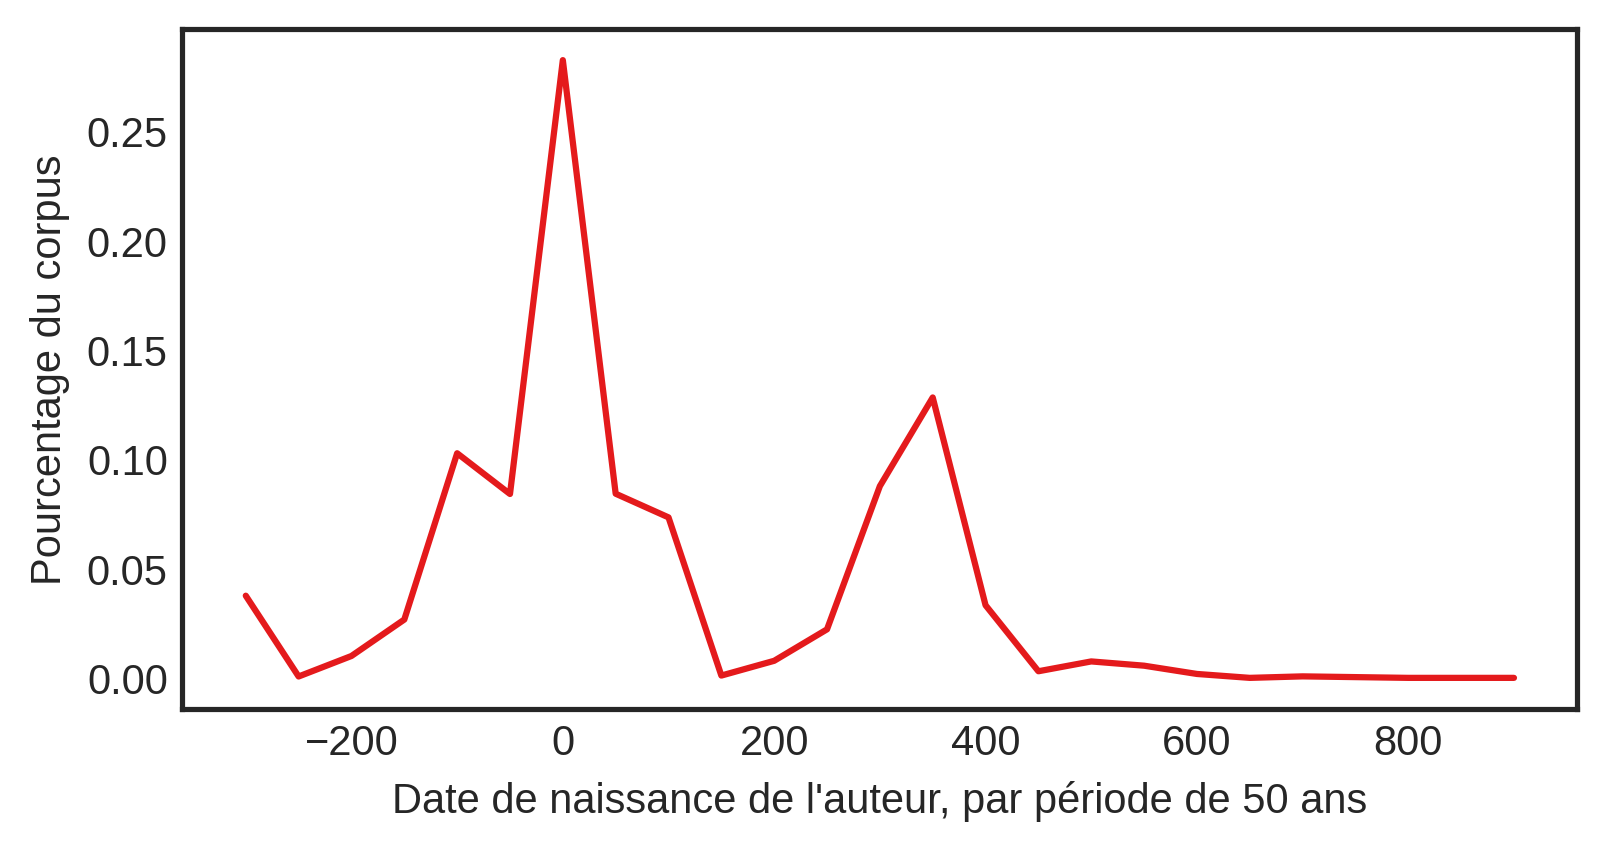

In [87]:
# import sns
#fig, (ax2, ax) = plt.subplots(2, 1, figsize=(6, 5), dpi=300, gridspec_kw={'height_ratios': [1, 3]})

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
sns.lineplot(data=NewDfBirth, x="Naissance", y="Mots",
    palette="Greys", )
ax.set_ylabel("Pourcentage du corpus")
ax.set_xlabel("Date de naissance de l'auteur, par période de 50 ans")
#NewDfBirth.Mots.sum()

Text(0.5, 0, "Date de naissance de l'auteur, par période de 50 ans")

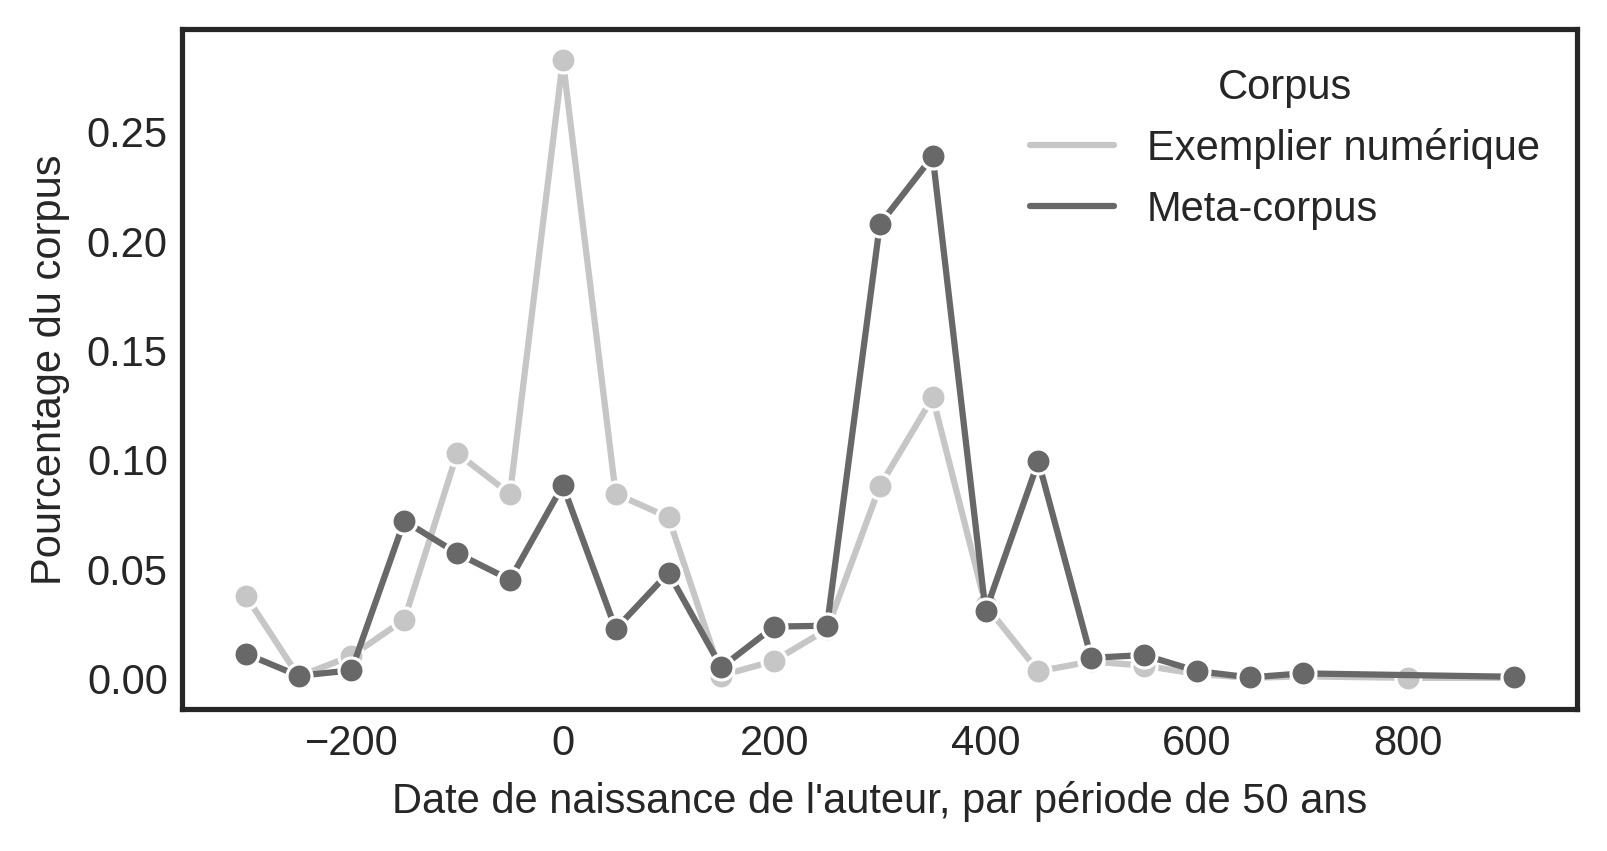

In [142]:
ConcatDF = pd.concat([NewDfBirth, CapitainsDf], keys=["Exemplier numérique", "Meta-corpus"]).reset_index(level=0)
ConcatDF.columns = ["Corpus", "Naissance", "Mots"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
sns.lineplot(
    data=ConcatDF, 
    x="Naissance", y="Mots", 
    #markers=["x", "<"], 
    #dashes= False,
    #style="Corpus",
    hue="Corpus",
    palette="Greys",
    ax=ax,
    marker="o"
)
ax.set_ylabel("Pourcentage du corpus")
ax.set_xlabel("Date de naissance de l'auteur, par période de 50 ans")

## Évolution accumulation comparée Exemplier / Meta-corpus

Text(0.5, 0, "Date de naissance de l'auteur, par période de 50 ans")

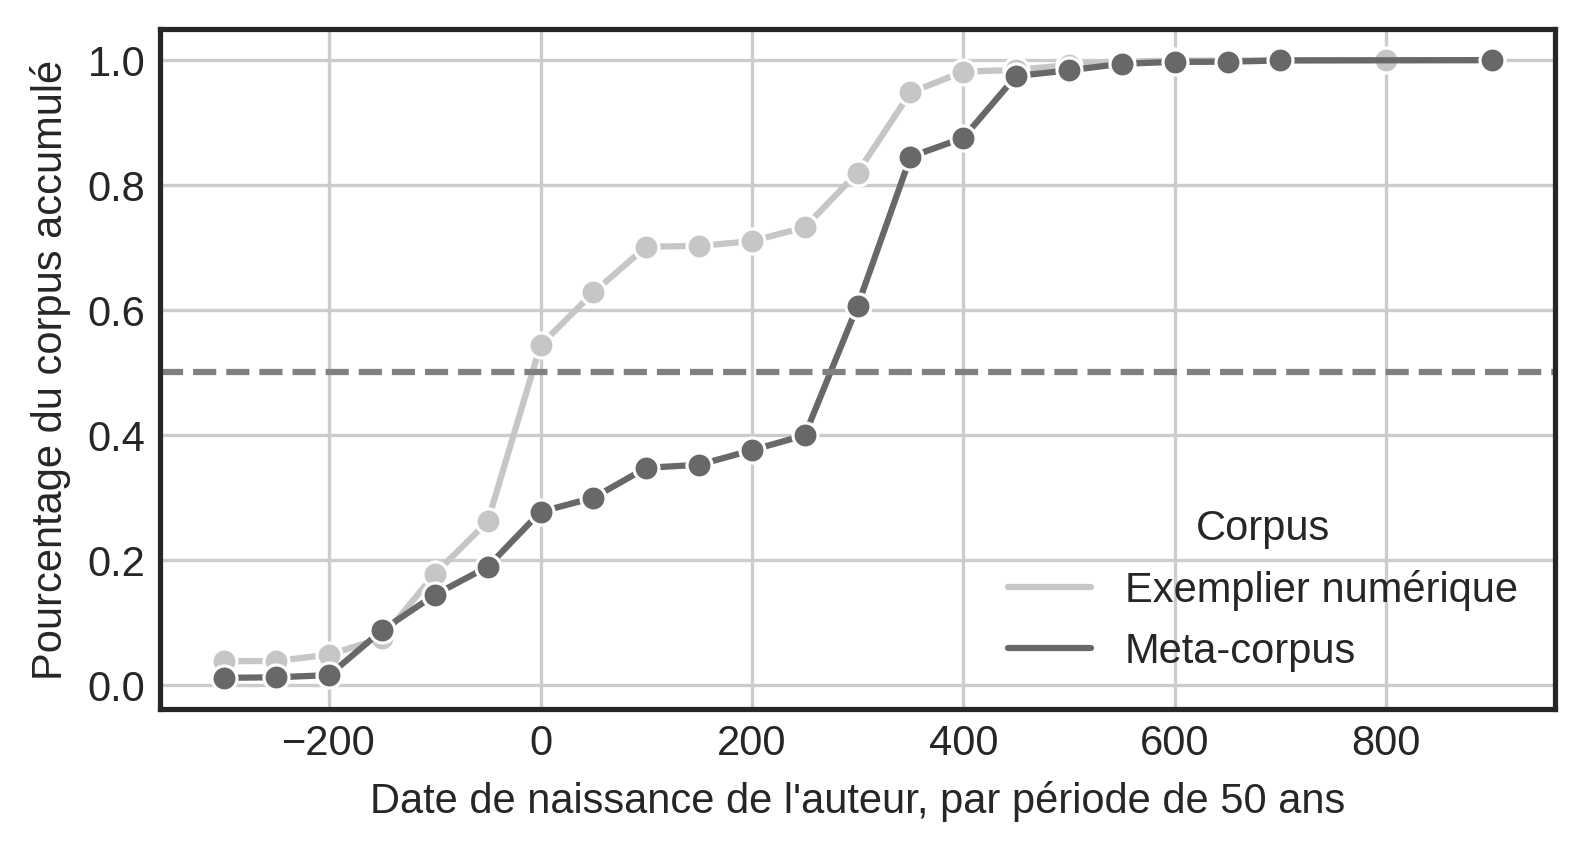

In [140]:
NewDfBirth2 = NewDfBirth.sort_values("Naissance")
NewDfBirth2["Mots"] = NewDfBirth2["Mots"].cumsum()

CapitainsDf2 = CapitainsDf.sort_values("Naissance")
CapitainsDf2["Mots"] = CapitainsDf2["Mots"].cumsum()

ConcatDF = pd.concat([NewDfBirth2, CapitainsDf2], keys=["Exemplier numérique", "Meta-corpus"]).reset_index(level=0)
ConcatDF.columns = ["Corpus", "Naissance", "Mots"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
sns.lineplot(
    data=ConcatDF, 
    x="Naissance", y="Mots", 
    #markers=["x", "<"], 
    #dashes= False,
    #style="Corpus",
    hue="Corpus",
    palette="Greys",
    ax=ax,
    marker="o"
)

plt.grid()

plt.axhline(y=0.5, color='gray', linestyle='--')

ax.set_ylabel("Pourcentage du corpus accumulé")
ax.set_xlabel("Date de naissance de l'auteur, par période de 50 ans")

## Évolution brute nombre / tags

In [90]:
new_data = []


NS = {"t": "http://www.tei-c.org/ns/1.0"}
xml = ET.parse("these-corpus/collated.xml")

DateRange = 50

total = len(xml.xpath("//t:div", namespaces=NS))

for div in xml.xpath("//t:div", namespaces=NS):
    #print(div.attrib["ana"])
    #print(ET.tostring(div))
    urn = div.xpath(".//t:idno[@type='CTS_URN']/text()", namespaces=NS)[0]
    textgroup = str((URN(urn)).upTo(URN.TEXTGROUP))
    
    infos = {
        "Type": "Métaphore" if "metaphore" in div.attrib["ana"] else "Métonymie" if "metonymie" in div.attrib["ana"] else "Autres",
        "Auteur": NomsFr.get(textgroup, "Inconnu"),
        "Naissance": dates.get(textgroup, AdditionalDates.get(textgroup, (-999,)))[0] // DateRange * DateRange,
        "Extraits": 1 / total
    }
    if infos["Naissance"] == -1000:
        continue
    new_data.append(infos)

TagsDataframe = DataFrame(new_data)

Text(0.5, 0, "Date de naissance de l'auteur, par période de 50 ans")

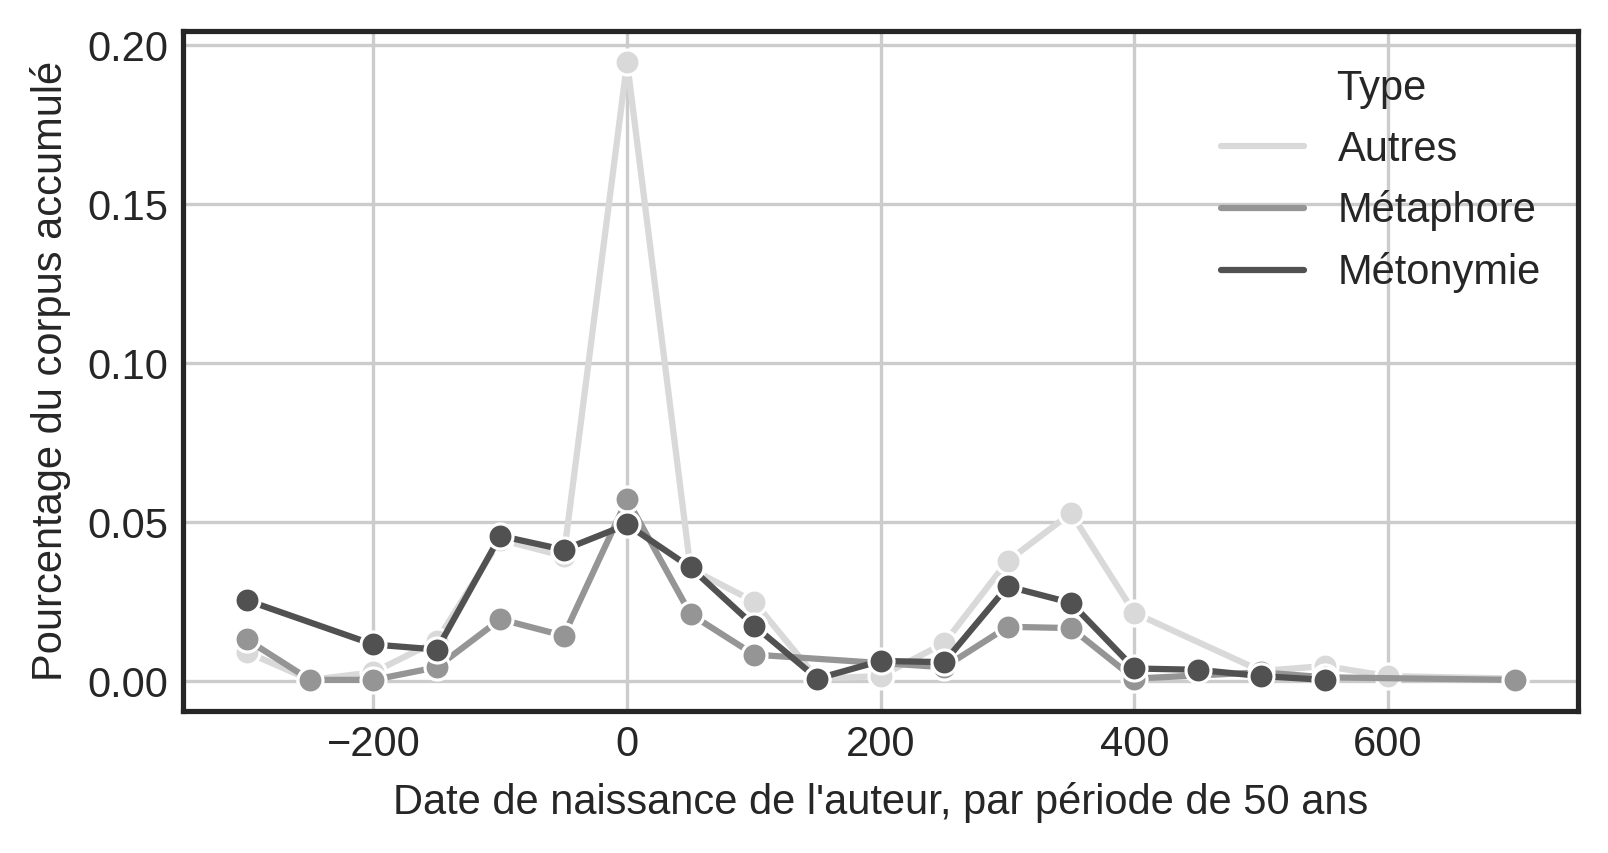

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

TagsDataframe2 = TagsDataframe.groupby(["Type", "Naissance"]).Extraits.sum().reset_index()
#print(TagsDataframe2)
sns.lineplot(
    data=TagsDataframe2, 
    x="Naissance", y="Extraits", 
    #markers=["x", "<"], 
    #dashes= False,
    #style="Corpus",
    hue="Type",
    palette="Greys",
    ax=ax,
    marker='o'
)

plt.grid()

# plt.axhline(y=0.5, color='gray', linestyle='--')

ax.set_ylabel("Pourcentage du corpus accumulé")
ax.set_xlabel("Date de naissance de l'auteur, par période de 50 ans")

## Nombre d'auteurs par période

Text(0.5, 0, "Date de naissance de l'auteur, par période de 50 ans")

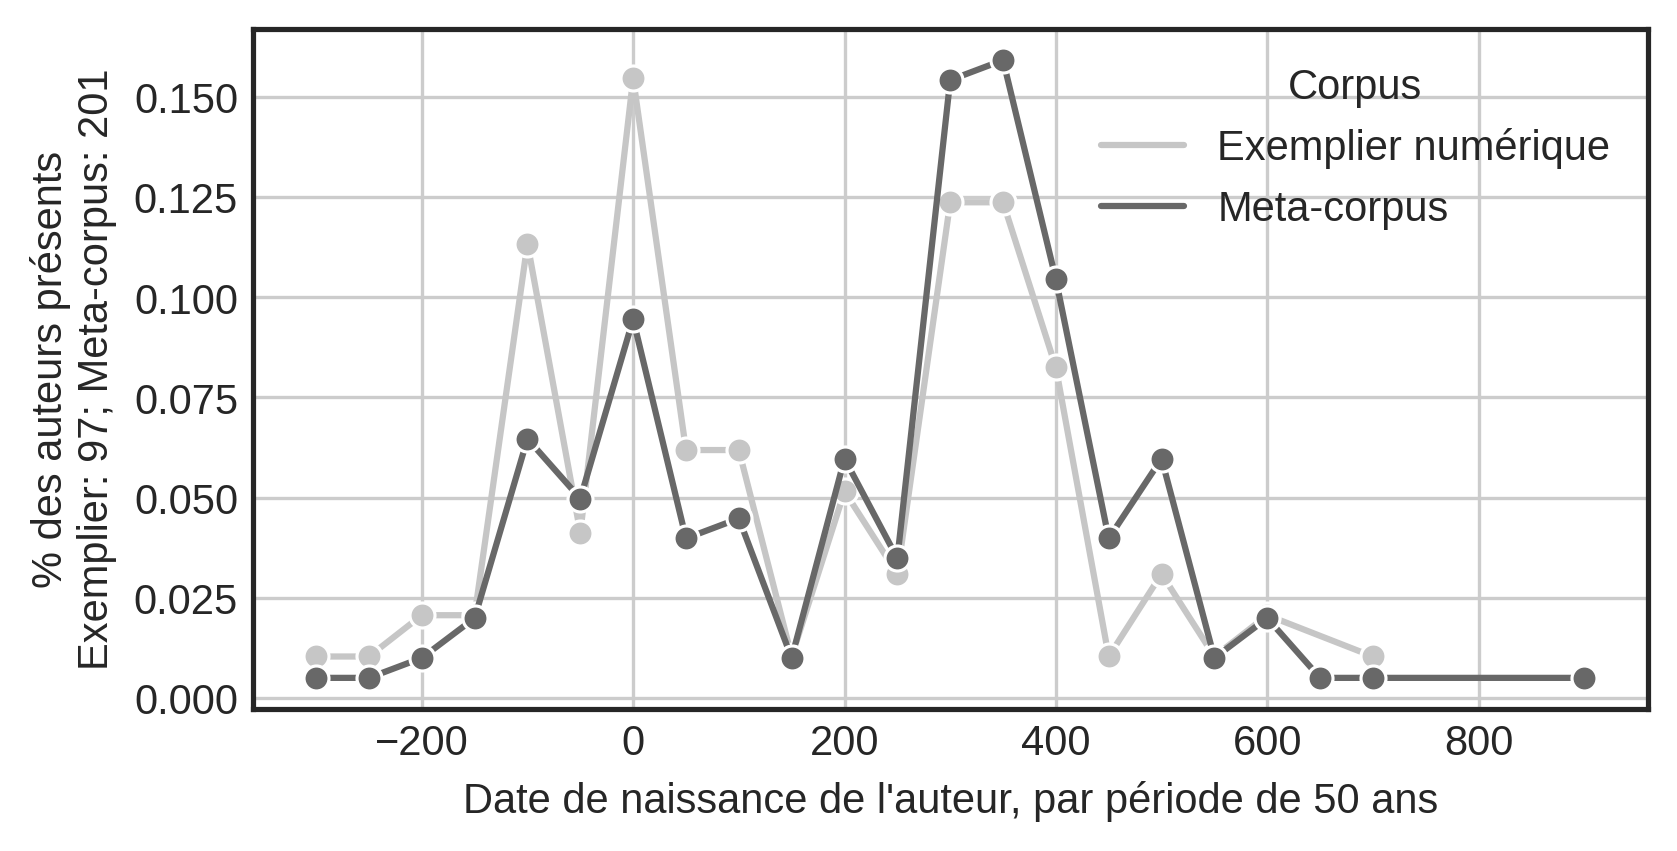

In [138]:
TagsDataframe3 = TagsDataframe.copy()
TagsDataframe3 = TagsDataframe3.groupby(["Auteur", "Naissance"])["Extraits"].max().reset_index()
TagsDataframe3["Extraits"] = 1
TagsDataframe3 = TagsDataframe3.groupby(["Naissance"])["Extraits"].sum().reset_index()
TagsDataframe3 = TagsDataframe3.sort_values("Naissance")
Total = TagsDataframe3["Extraits"].sum()
TagsDataframe3["Extraits"] = TagsDataframe3["Extraits"] / Total
TagsDataframe3["Corpus"] = "Exemplier numérique"
#TagsDataframe3["Extraits"] = TagsDataframe3["Extraits"].cumsum() / Total

Auteurs2 = DataFrame([{
    "Extraits": 1,
    "Auteur": key,
    "Naissance": value[0] // DateRange * DateRange,
    "Corpus": "Meta-corpus"
} for key, value in dates.items()])
Auteurs2 = Auteurs2.groupby(["Naissance"])["Extraits"].sum().reset_index()
Auteurs2 = Auteurs2.sort_values("Naissance")
TotalAuteurs2 = Auteurs2["Extraits"].sum()
Auteurs2["Extraits"] = Auteurs2["Extraits"] / TotalAuteurs2
Auteurs2["Corpus"] = "Meta-corpus"



# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
sns.lineplot(
    data=pd.concat([TagsDataframe3, Auteurs2]), 
    x="Naissance", y="Extraits",
    hue="Corpus",
    palette="Greys", 
    marker='o',
    ax=ax,
    markers=True
)

plt.grid()

ax.set_ylabel(f"% des auteurs présents\nExemplier: {Total}; Meta-corpus: {TotalAuteurs2}")
ax.set_xlabel("Date de naissance de l'auteur, par période de 50 ans")